In [1]:
import numpy as np
from astropy.io import fits
import astroalign as aa
from reproject import reproject_interp
from astropy.wcs import WCS
from photutils.background import Background2D, SExtractorBackground
from astropy.stats import SigmaClip, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel, convolve
import astropy.units as u
from astropy.modeling import models, fitting

import sys
sys.path.append("../analysis")
import phot

In [2]:
#Zoom in region around the target. 
ix1_z = 30# 25
ix2_z = 110
iy1_z = 960
iy2_z = 1080

In [3]:
#Read an image, the o-mask and the e-mask
data_folder = "../analysis/crz"
mask_folder = "../analysis/masks"
object = "W0204-0506"
band = "R_SPECIAL"
ichip = 1
mjd = 60207
#mjd = 60209

ref_name = "{}.{}.{}".format(object, band, mjd)

ex_ref = 1012.7
ey_ref = 54.8
e_pos_ref = np.vstack((ex_ref,ey_ref)).T

dx = np.zeros(8)
dy = np.zeros(8)
th = np.zeros(8)
seeing = np.zeros(8)

for i in range(1,9):
    fname = "{}/science_reduced_img.{}.{}.{}.chip{}.{}.crz.fits".format(data_folder, object, mjd, band, ichip, i)
    mname = "{}/science_reduced_img.{}.{}.{}.chip{}.{}.{{}}.fits".format(mask_folder, object, mjd, band, ichip, i)

    im = fits.open(fname)
    mask  = fits.open(mname.format("mask"))
    omask = fits.open(mname.format("omask"))
    emask = fits.open(mname.format("emask"))
 
    fname = "science_reduced_img.W0204-0506.60207.R_SPECIAL.chip1.{}.crz.fits".format(i)
    e_pos = phot.dao_recenter(fname, e_pos_ref, emask[0].data, "e", "../analysis/crz/", box_size=7)
    o_pos = phot.dao_recenter(fname, e_pos_ref, omask[0].data, "o", "../analysis/crz/", box_size=7)

    dx[i-1], dy[i-1] = (e_pos-o_pos)[0]

    th[i-1] = im[0].header["HIERARCH ESO INS RETA2 ROT"]
    #seeing[i-1] = im[0].header["HIERARCH ESO TEL IA FWHMLINOBS"]

2.1345882543562653 2.3410883208687014


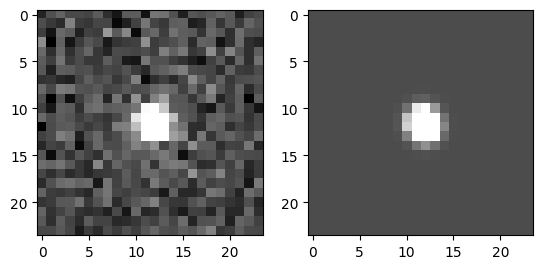

2.129896575578207 2.209207487002498


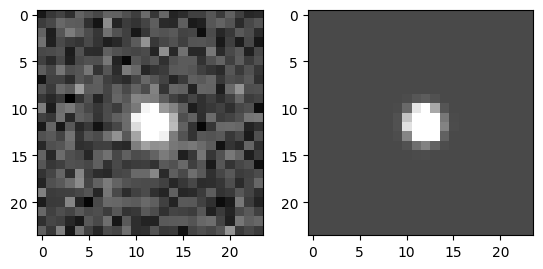

2.053742580184476 2.141484001937545


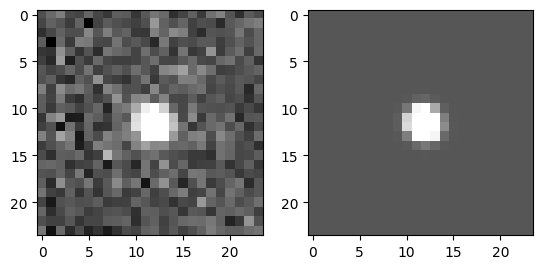

2.6709827597185365 2.5381197569442655


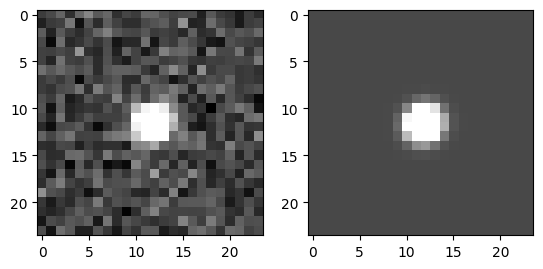

2.2205435652988457 2.1550244074729235


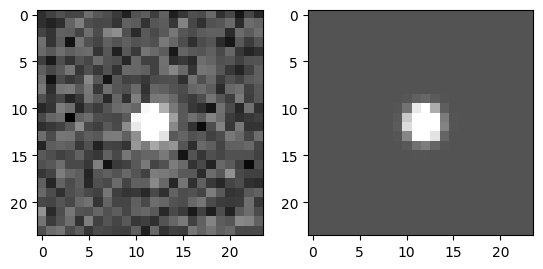

2.388093173031727 2.5786994369510996


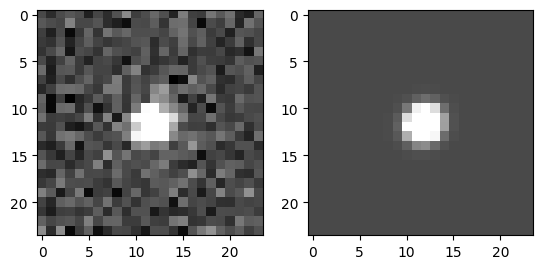

2.5597763040026322 2.5026170225511954


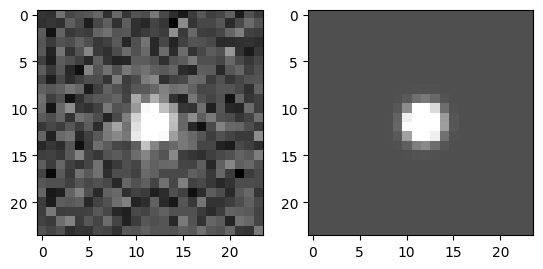

2.70484075265574 2.567432772135481


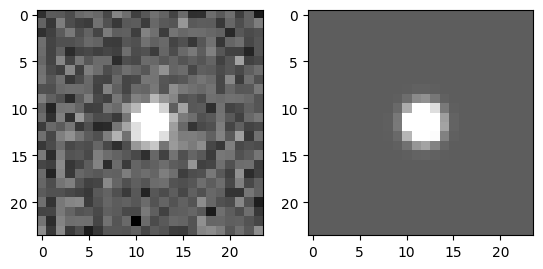

In [4]:
for i in range(1,9):
    fname = "{}/science_reduced_img.{}.{}.{}.chip{}.{}.crz.fits".format(data_folder, object, mjd, band, ichip, i)
    mname = "{}/science_reduced_img.{}.{}.{}.chip{}.{}.{{}}.fits".format(mask_folder, object, mjd, band, ichip, i)

    im = fits.open(fname)

    x_size = 24#20
    y_size = 24#20
    ix1 = int(ex_ref-x_size/2)
    ix2 = int(ex_ref+x_size/2)
    iy1 = int(ey_ref-y_size/2)
    iy2 = int(ey_ref+y_size/2)
    y, x = np.mgrid[:x_size, :y_size]
    z = im[0].data[iy1:iy2, ix1:ix2]
    z_err = im[1].data[iy1:iy2, ix1:ix2]
    z -= np.median(z)

    from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize
    import matplotlib.pyplot as plt
    norm = ImageNormalize(z, interval=ZScaleInterval(), stretch=LinearStretch())
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(z, norm=norm, cmap='gray')

    mod1 = models.Gaussian2D(x_mean=x_size/2, y_mean=y_size/2, x_stddev=1.1, y_stddev=1.1)#x_stddev=0.95, y_stddev=0.95)
    mod2 = models.Const2D(amplitude=0)
    stddev_tied = lambda model: model.x_stddev
    p_init = mod1#+mod2

    #p_init.y_stddev.tied = stddev_tied
    p_init.x_mean.min = 0
    p_init.x_mean.max = x_size
    p_init.y_mean.min = 0
    p_init.y_mean.max = y_size
    p_init.x_stddev.min = 0.
    p_init.x_stddev.max = 5.
    p_init.y_stddev.min = 0.
    p_init.y_stddev.max = 5.
    # p_init.amplitude_1.min = 0.
    # p_init.amplitude_1.max = 0.
    # p_init.amplitude_1.fixed = True

    fit_p = fitting.LevMarLSQFitter()
    p = fit_p(p_init, x, y, z)#, weights=1./z_err)
    seeing[i-1] = np.mean([p.x_fwhm,p.y_fwhm])*im[0].header["HIERARCH ESO INS PIXSCALE"]*im[0].header["HIERARCH ESO DET WIN1 BINX"]
    print(p.x_fwhm, p.y_fwhm)

    axs[1].imshow(p(x,y), norm=norm, cmap='gray')
    plt.show()


In [5]:
seeing

array([0.56393525, 0.54672711, 0.52859855, 0.65634692, 0.55132156,
       0.62581587, 0.63786156, 0.66430646])

In [6]:
#target_fwhm = np.max(seeing)
#target_fwhm = 0.7
target_fwhm = np.ceil(np.max(seeing)*10)/10.
print(target_fwhm)

0.7


In [7]:
dx_use = np.round(np.median(dx), 1)
dy_use = np.round(np.median(dy), 1)
print(dx_use, dy_use)

-0.2 -90.5


In [8]:
for i in range(1,9):
    fname = "{}/science_reduced_img.{}.{}.{}.chip{}.{}.crz.fits".format(data_folder, object, mjd, band, ichip, i)
    mname = "{}/science_reduced_img.{}.{}.{}.chip{}.{}.{{}}.fits".format(mask_folder, object, mjd, band, ichip, i)

    im = fits.open(fname)
    mask  = fits.open(mname.format("mask"))
    omask = fits.open(mname.format("omask"))
    emask = fits.open(mname.format("emask"))

    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(im[0].data, (50,50), filter_size=(3,3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, coverage_mask=mask[0].data.astype(bool))
    im[0].data -= bkg.background

    input_wcs = WCS(naxis=2)
    input_wcs.wcs.crpix = o_pos[0] #128.5, 128.5
    input_wcs.wcs.cdelt = 1., 1.#-0.01, 0.01

    output_wcs = WCS(naxis=2)
    output_wcs.wcs.crpix = input_wcs.wcs.crpix + (dx_use, dy_use)
    output_wcs.wcs.cdelt = input_wcs.wcs.cdelt

    if i==1:
        oim = np.zeros((8, im[0].data.shape[0], im[0].data.shape[1]))
        eim = np.zeros(oim.shape)
    oim_aux = im[0].data*(1-omask[0].data)
    eim[i-1] = im[0].data*(1-emask[0].data)

    oim[i-1], _ = reproject_interp((oim_aux, input_wcs), output_wcs, shape_out=eim[i-1].shape, order='bicubic') #order='nearest-neighbor')

    #Convolve images to a common PSF.
    if seeing[i-1] < target_fwhm:
        stddev_image = gaussian_fwhm_to_sigma*seeing[i-1]/(im[0].header["HIERARCH ESO INS PIXSCALE"]*im[0].header["HIERARCH ESO DET WIN1 BINX"])
        stddev_targ = gaussian_fwhm_to_sigma*target_fwhm/(im[0].header["HIERARCH ESO INS PIXSCALE"]*im[0].header["HIERARCH ESO DET WIN1 BINX"])
        stddev = (stddev_targ**2-stddev_image**2)**0.5
        print(stddev, stddev * im[0].header["HIERARCH ESO INS PIXSCALE"]*im[0].header["HIERARCH ESO DET WIN1 BINX"])
        gauss = Gaussian2DKernel(x_stddev=stddev)
        eim[i-1] = convolve(eim[i-1], gauss, mask=emask[0].data)
        oim[i-1] = convolve(oim[i-1], gauss, mask=emask[0].data)

    fits.writeto("oim.{}.{}.fits".format(ref_name, i), oim[i-1, ix1_z:ix2_z,iy1_z:iy2_z], overwrite=True)
    fits.writeto("eim.{}.{}.fits".format(ref_name, i), eim[i-1, ix1_z:ix2_z,iy1_z:iy2_z], overwrite=True)

0.6988387278032016 0.1761073594064068


0.7366481586420904 0.1856353359778068


0.7733106315116267 0.19487427914092995


0.41004789578253953 0.10333206973719997


0.726859031117387 0.18316847584158152


0.5284925248220912 0.13318011625516699


0.48587829500328594 0.12244133034082806


0.37187115248082203 0.09371153042516715


In [9]:
#Get the Stoke parameter images. 
all_th_S = np.unique(th)
Q = np.zeros(oim.shape[1:])
U = np.zeros(Q.shape)
for j, th_S in enumerate(all_th_S):
    k = np.where(th==th_S)
    fo = np.sum(oim[k], axis=0)
    fe = np.sum(eim[k], axis=0)
    F = (fo-fe)/(fo+fe)
    Q += (2/len(all_th_S)) * F * np.cos(4*th_S*u.deg)
    U += (2/len(all_th_S)) * F * np.sin(4*th_S*u.deg)

/var/folders/p7/drxzchtj4yb641v79lt0tjyh0000gn/T/ipykernel_45164/2540475989.py:9: RuntimeWarning: invalid value encountered in divide
  F = (fo-fe)/(fo+fe)


In [10]:
#Calculate the polarization image. 
pol = (Q**2+U**2)**0.5

In [11]:
#Make a stack of everything. 
stack = oim.sum(axis=0) + eim.sum(axis=0)
fits.writeto("stack.{}.fits".format(ref_name), (stack*(1-emask[0].data))[ix1_z:ix2_z,iy1_z:iy2_z], overwrite=True)
diff = oim.sum(axis=0) - eim.sum(axis=0)
fits.writeto("diff.{}.fits".format(ref_name), (diff*(1-emask[0].data))[ix1_z:ix2_z,iy1_z:iy2_z], overwrite=True)

In [12]:
#Make source mask from the stack and save the masked polarization and polarization angle images.
rms = np.std(stack[ix1_z:ix2_z,iy1_z:iy2_z])
print(rms)
source_mask = np.ones(stack.shape)
source_mask[stack>2*rms] = 0
masked_pol = pol * (1-source_mask)
fits.writeto("masked_pol.{}.fits".format(ref_name), masked_pol[ix1_z:ix2_z,iy1_z:iy2_z], overwrite=True)

pol_angle = 0.5*np.arctan2(U,Q)*180./np.pi
fits.writeto("masked_pol_angle.{}.fits".format(ref_name), np.where(source_mask, np.nan, pol_angle)[ix1_z:ix2_z,iy1_z:iy2_z], overwrite=True)

1015.3165501568863
